# Tensorflow: Basic Text Classification - Multiclass Label, with Hyperparameter Tuning via HParams

Reference:
* https://www.tensorflow.org/tutorials/keras/text_classification#exercise_multi-class_classification_on_stack_overflow_questions
* https://www.tensorflow.org/tutorials/keras/keras_tuner

## Setup

In [4]:
import io, os, re, shutil
import string
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 300

import tensorflow as tf
from tensorflow.keras import layers, losses

# Hyperparameter tuner using Keras Tuner
import keras_tuner as kt

%load_ext tensorboard

## Download the Stack Overflow Dataset

In [5]:
# Prepare to download the dataset to be used to the location CACHE_DIR/DATASET_SUBDIR
CACHE_DIR = '.\\data'
DATASET_URL = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
DATASET_SUBDIR = 'stackoverflowdb'
DATASET_ZIPFILE = 'stack_overflow_16k.tar.gz'

In [6]:
# Download the targeted dataset
# dataset = tf.keras.utils.get_file(
#             DATASET_ZIPFILE, DATASET_URL,
#             untar=True, cache_dir=CACHE_DIR, cache_subdir=DATASET_SUBDIR)

In [7]:
dataset_dir = os.path.join( CACHE_DIR, DATASET_SUBDIR )
print(dataset_dir)
os.listdir(dataset_dir)

.\data\stackoverflowdb


['README.md', 'stack_overflow_16k.tar.gz', 'test', 'train']

In [8]:
# Get the directory name of the training data
train_dir = os.path.join(dataset_dir, 'train')
print(train_dir)
os.listdir(train_dir)

.\data\stackoverflowdb\train


['csharp', 'java', 'javascript', 'python']

In [9]:
test_dir = os.path.join(dataset_dir, 'test')
print(test_dir)
os.listdir(test_dir)

.\data\stackoverflowdb\test


['csharp', 'java', 'javascript', 'python']

In [10]:
# # Remove directory containing unsupervised examples
# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

In [11]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
            train_dir, batch_size=batch_size,
            validation_split=0.2, subset='training',
            seed=seed)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
            train_dir, batch_size=batch_size,
            validation_split=0.2, subset='validation',
            seed=seed)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
            test_dir, batch_size=batch_size)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [12]:
for i,c in enumerate(raw_train_ds.class_names):
    print(f"Label: {i} => Class: {c}")

Label: 0 => Class: csharp
Label: 1 => Class: java
Label: 2 => Class: javascript
Label: 3 => Class: python


In [13]:
# for text_batch, label_batch in raw_train_ds.take(1):
#   for i in range(1):
#     print(f"Label: {label_batch.numpy()[i]} ({raw_train_ds.class_names[label_batch.numpy()[i]]})"
#           f" => Post: {text_batch.numpy()[i]}")

## Text Preprocessing

In [14]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    stripped_punct = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
    return stripped_punct

In [15]:
# Vocabulary size (features) and number of words in a sequence (review).
# max_features = 10000
# sequence_length = 250
max_features = 15000
sequence_length = 350

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = layers.TextVectorization(
                    standardize=custom_standardization,
                    max_tokens=max_features,
                    output_mode='int',
                    output_sequence_length=sequence_length)

In [16]:
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [18]:
# # retrieve a batch (of 32 reviews and labels) from the dataset
# text_batch, label_batch = next(iter(raw_train_ds))
# first_review, first_label = text_batch[0], label_batch[0]
# print("Review", first_review)
# print("Label", raw_train_ds.class_names[first_label])
# print("Vectorized review", vectorize_text(first_review, first_label))

In [19]:
# print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
# print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
# print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

In [20]:
# Create vectorized training, validation, and test datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [21]:
# [ x for x in train_ds.take(1).as_numpy_iterator() ]
# print(dir(train_ds))

## Configure the Dataset for Performance

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create a function to build and compile a model

In [23]:
def model_builder(hp):
    model = tf.keras.Sequential()
        
    # Tune the embedding dimensions
    hp_embedding_dims = hp.Int('embedding_dimensions', min_value=16, max_value=64, step=16)
    model.add( layers.Embedding( max_features+1, hp_embedding_dims ) )

    # Tune the dropout rate in the first Dropout layer
    hp_dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.0, max_value=0.3, step=0.1)
    model.add( layers.Dropout(hp_dropout_rate_1) )
    
    model.add( layers.GlobalAveragePooling1D() )

    # Tune the dropout rate in the second Dropout layer
    hp_dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.0, max_value=0.3, step=0.1)
    model.add( layers.Dropout(hp_dropout_rate_2) )
    
    model.add( layers.Dense(4) )
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])    
    model.compile(
        optimizer=tf.keras.optimizers.Adam( learning_rate=hp_learning_rate ),
        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
        )    
    
    return model


## Create a Classification Model

In [24]:
# embedding_dim = 32
# model = tf.keras.Sequential( [
#     layers.Embedding( max_features+1, embedding_dim ),
#     layers.Dropout(0.2),
#     layers.GlobalAveragePooling1D(),
#     layers.Dropout(0.2),
#     layers.Dense(4)
#     ])

# model.summary()

## Compile and Train the Model

In [25]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
LOGS_ROOTDIR = os.path.join('.', 'logs')
this_run_log_dir = os.path.join( LOGS_ROOTDIR, "fit_" + dt.datetime.now().strftime("%Y%m%d-%H%M%S") )
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=this_run_log_dir, histogram_freq=1)
print(f"Prepared Tensorboard log dir: {this_run_log_dir}")

# Stop epochs if validation loss is increasing
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Prepared Tensorboard log dir: .\logs\fit_20211119-153512


In [26]:
# model.compile(
#     optimizer='adam',
#     loss=losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
#     )

In [27]:
# epochs = 100
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=epochs,
#     callbacks=[tensorboard_callback, earlystopping_callback]
#     )

## Instantiate the Tuner and Perform Hypertuning

In [28]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='hpt_dir',
                     project_name='nlp_multiclass_hpt')

In [29]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[earlystopping_callback]
    )

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters( num_trials=1 )[0]
print(f"Optimal hyperparameters:\n{best_hps.values}")

Trial 243 Complete [00h 01m 50s]
val_accuracy: 0.8412500023841858

Best val_accuracy So Far: 0.8418750166893005
Total elapsed time: 01h 10m 54s
INFO:tensorflow:Oracle triggered exit
Optimal hyperparameters:


In [35]:
# Best hyperparameter tuning values
best_hps.values

# Tuned hyperparameters: 11/19/21 (Trials: 243, Total elapsed time: 01h 10m 54s, Best val_accuracy So Far: 0.8418750166893005)
# {'embedding_dimensions': 64,
#  'dropout_rate_1': 0.30000000000000004,
#  'dropout_rate_2': 0.1,
#  'learning_rate': 0.001,
#  'tuner/epochs': 100,
#  'tuner/initial_epoch': 34,
#  'tuner/bracket': 2,
#  'tuner/round': 2,
#  'tuner/trial_id': '46926b7279b8fa2bcff7683fa23a921d'}

{'embedding_dimensions': 64,
 'dropout_rate_1': 0.30000000000000004,
 'dropout_rate_2': 0.1,
 'learning_rate': 0.001,
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '46926b7279b8fa2bcff7683fa23a921d'}

## Train the Tuned Model

In [36]:
# Stop epochs if validation loss is increasing
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model with the optimal hyperparameters obtained from the tuner search above
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,
    callbacks=[tensorboard_callback, earlystopping_callback]
    )

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/150
200/200 [==============================] - 6s 27ms/step - loss: 1.3728 - accuracy: 0.3666 - val_loss: 1.3534 - val_accuracy: 0.4731
Epoch 2/150
200/200 [==============================] - 5s 25ms/step - loss: 1.3165 - accuracy: 0.5167 - val_loss: 1.2766 - val_accuracy: 0.6006
Epoch 3/150
200/200 [==============================] - 5s 25ms/step - loss: 1.2144 - accuracy: 0.5969 - val_loss: 1.1626 - val_accuracy: 0.6650
Epoch 4/150
200/200 [==============================] - 5s 25ms/step - loss: 1.0897 - accuracy: 0.6737 - val_loss: 1.0471 - val_accuracy: 0.7038
Epoch 5/150
200/200 [==============================] - 5s 27ms/step - loss: 0.9729 - accuracy: 0.7186 - val_loss: 0.9466 - val_accuracy: 0.7394
Epoch 6/150
200/200 [==============================] - 5s 25ms/step - loss: 0.8727 - accuracy: 0.7536 - val_loss: 0.8648 - val_accuracy: 0.7550
Epoch 7/150
200/200 [==============================] - 5s 25ms/step - loss: 0.7897 - accuracy: 0.7780 - val_loss: 0.7994 - val_accuracy:

In [40]:
# Reinstantiate and retrain the model with the
# optimal hyperparameters and optimal number of epochs determined above
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(
    train_ds,
    validation_data=val_ds,
    epochs=best_epoch,
    callbacks=[tensorboard_callback]
    )

Epoch 1/23
200/200 [==============================] - 7s 32ms/step - loss: 1.3729 - accuracy: 0.3595 - val_loss: 1.3534 - val_accuracy: 0.4725
Epoch 2/23
200/200 [==============================] - 5s 26ms/step - loss: 1.3159 - accuracy: 0.5161 - val_loss: 1.2758 - val_accuracy: 0.5900
Epoch 3/23
200/200 [==============================] - 5s 26ms/step - loss: 1.2131 - accuracy: 0.6002 - val_loss: 1.1628 - val_accuracy: 0.6650
Epoch 4/23
200/200 [==============================] - 5s 26ms/step - loss: 1.0913 - accuracy: 0.6678 - val_loss: 1.0486 - val_accuracy: 0.7019
Epoch 5/23
200/200 [==============================] - 5s 27ms/step - loss: 0.9743 - accuracy: 0.7220 - val_loss: 0.9486 - val_accuracy: 0.7369
Epoch 6/23
200/200 [==============================] - 5s 27ms/step - loss: 0.8749 - accuracy: 0.7523 - val_loss: 0.8669 - val_accuracy: 0.7588
Epoch 7/23
200/200 [==============================] - 5s 27ms/step - loss: 0.7914 - accuracy: 0.7794 - val_loss: 0.8008 - val_accuracy: 0.7681

## Evaluate the Model

250/250 [==============================] - 1s 3ms/step - loss: 0.5454 - accuracy: 0.8011
Loss:  0.5454238653182983
Accuracy:  0.8011249899864197
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


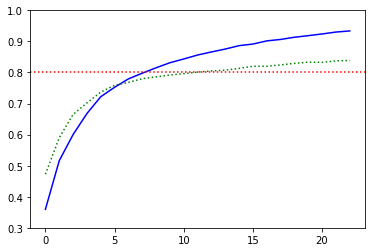

In [41]:
loss, accuracy = hypermodel.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

history_dict = history.history
print( history_dict.keys() )

plt.plot( 'accuracy', 'b-', data=history.history )
plt.plot( 'val_accuracy', 'g:', data=history.history )
# plt.plot( [accuracy]*len(history.history['binary_accuracy']), 'r--', data=history.history )
y_axis_min_val = max( 0, round(min(accuracy, min(history.history['val_accuracy']), min(history.history['accuracy']) )-0.1, 1) )
_ = plt.ylim( y_axis_min_val, 1.0)
plt.axhline( accuracy, color='r', linestyle=':')

In [43]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 23932), started 2 days, 3:58:36 ago. (Use '!kill 23932' to kill it.)

## Export the Model

In [44]:
# Wrap the trained model to permit it to be used directly in input strings (vs. vectors)
# and then apply an activation layer to yield a floating result between 0 and 1
export_model = tf.keras.Sequential([
    vectorize_layer,
    hypermodel,
    layers.Softmax()
    ])

export_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 350)               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 4)                 960324    
_________________________________________________________________
softmax (Softmax)            (None, 4)                 0         
Total params: 960,324
Trainable params: 960,324
Non-trainable params: 0
_________________________________________________________________


In [45]:
export_model.compile(
    optimizer="adam",
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )

In [46]:
# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 4s 13ms/step - loss: 0.5454 - accuracy: 0.8011
0.8011249899864197


In [48]:
# Some test examples
n_examples = 32
examples_np = [ x for x in raw_test_ds.take(n_examples).as_numpy_iterator() ]
examples = [ x[0][0].decode() for x in examples_np ]
true_labels = [ x[1][0] for x in examples_np ]
true_classes = [ raw_train_ds.class_names[label] for label in true_labels ]

preds = export_model.predict(examples)
pred_labels = list(np.argmax(preds, axis=1))
pred_classes = [ raw_train_ds.class_names[label] for label in pred_labels ]
r_df = pd.concat([
        pd.DataFrame( {'Post': examples,
                       'True Label': true_labels, 'True Class': true_classes,
                       'Predicted Label': pred_labels, 'Predicted Class': pred_classes
                      }),
        pd.DataFrame( preds, columns=['c0 (csharp)', 'c1 (java)', 'c2 (javascript)', 'c3 (python)'] ),
        pd.DataFrame( np.max(preds, axis=1) / np.mean(preds, axis=1), columns=['max/mean'] )
        ], axis=1 )
r_df['Prediction Correct'] = r_df['Predicted Label'] == r_df['True Label']
r_df = r_df[['Post', 'True Label', 'True Class', 'Predicted Label',
       'Predicted Class', 'c0 (csharp)', 'c1 (java)', 'c2 (javascript)',
       'c3 (python)', 'max/mean', 'Prediction Correct']]
r_df.sort_values(by=['Prediction Correct', 'max/mean'], ascending=[False, False], inplace=True)
r_df

,Post,True Label,True Class,Predicted Label,Predicted Class,c0 (csharp),c1 (java),c2 (javascript),c3 (python),max/mean,Prediction Correct
16,"""running total instead of individual total? i'...",1,java,1,java,0.000,1.000,0.000,0.000,4.000,True
12,getting blank.lang.verifyerror: class waffle.a...,1,java,1,java,0.000,1.000,0.000,0.000,3.999,True
31,"""just some thing i am working on that is broke...",1,java,1,java,0.000,1.000,0.000,0.000,3.999,True
25,"""save large list of ints in memory for fast ac...",0,csharp,0,csharp,1.000,0.000,0.000,0.000,3.999,True
26,"""blank file reader convert invalid literal i h...",3,python,3,python,0.000,0.000,0.000,1.000,3.999,True
23,"""how to create function x times i'm learning t...",2,javascript,2,javascript,0.000,0.000,0.999,0.000,3.998,True
22,"""why doesn't the else shown in code not work i...",3,python,3,python,0.000,0.001,0.000,0.999,3.996,True
4,"""how to skip a variable value in eval i have d...",3,python,3,python,0.000,0.001,0.000,0.999,3.996,True
15,"""i keep getting the error list assignment inde...",3,python,3,python,0.000,0.001,0.000,0.999,3.995,True
5,"""beginner index out of range in blank this is ...",3,python,3,python,0.000,0.004,0.000,0.996,3.983,True


## Retrieve the Trained Word Embeddings and Save them to Disk

In [ ]:
# weights = model.get_layer('embedding').get_weights()[0]
# vocab = vectorize_layer.get_vocabulary()

# with io.open('./data/vectors.tsv', 'w', encoding='utf-8') as out_v:
#     with io.open('./data/metadata.tsv', 'w', encoding='utf-8') as out_m:
#         for index, word in enumerate(vocab):
#             if index == 0:
#                 continue    # skip 0, it's padding
                
#             vec = weights[index]
#             out_v.write( '\t'.join( [ str(x) for x in vec ]) + '\n' )
#             out_m.write( word + '\n' )


## Visualize the Embeddings
* Tensorflow Embedding Projector: http://projector.tensorflow.org/
* Click on "Load data".
* Upload the two files you created above: vecs.tsv and meta.tsv.